In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [10]:
import gym
import gym_market
import numpy as np

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [11]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [1, 0, 0, 2, 0, 1, 1, 0, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0]
Rewards: [-4.55, -1.57, 1.41, -1.56, 1.29, -4.609999999999999, 3.32, -1.7200000000000002, -1.7600000000000002, -1.68, -1.73, -1.75, -1.77, -4.84, -1.8, 1.05, -1.85, -4.92, -1.96, -2.0, -2.04]
Return: 0.8537389815824445


In [12]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [13]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [14]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [15]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [16]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -31.610000000000007 Training loss: 18.9191 Explore P: 0.9979 Total return: 0.92
Episode: 2 Total reward: -8.82 Training loss: 7.5877 Explore P: 0.9959 Total return: 1.01
Episode: 3 Total reward: -14.95 Training loss: 3.8892 Explore P: 0.9938 Total return: 1.00
Episode: 4 Total reward: -11.049999999999999 Training loss: 6.7711 Explore P: 0.9917 Total return: 0.91
Episode: 5 Total reward: -28.570000000000004 Training loss: 8.3681 Explore P: 0.9897 Total return: 0.97
Episode: 6 Total reward: -9.589999999999998 Training loss: 4.8949 Explore P: 0.9876 Total return: 1.05
Episode: 7 Total reward: -31.580000000000002 Training loss: 4.2711 Explore P: 0.9856 Total return: 1.02
Episode: 8 Total reward: 14.950000000000001 Training loss: 3.0324 Explore P: 0.9835 Total return: 0.93
Episode: 9 Total reward: 5.19 Training loss: 4.1772 Explore P: 0.9815 Total return: 0.89
Episode: 10 Total reward: 1.7900000000000018 Training loss: 5.2939 Explore P: 0.9794 Total return: 1.08
Epi

Episode: 83 Total reward: 2.400000000000001 Training loss: 7.0267 Explore P: 0.8416 Total return: 0.97
Episode: 84 Total reward: -7.979999999999995 Training loss: 6.3521 Explore P: 0.8399 Total return: 0.71
Episode: 85 Total reward: 15.549999999999997 Training loss: 3.3319 Explore P: 0.8382 Total return: 1.10
Episode: 86 Total reward: -5.929999999999999 Training loss: 5.1345 Explore P: 0.8364 Total return: 0.92
Episode: 87 Total reward: -7.01 Training loss: 5.4596 Explore P: 0.8347 Total return: 1.03
Episode: 88 Total reward: -0.99 Training loss: 7.0215 Explore P: 0.8330 Total return: 1.07
Episode: 89 Total reward: -11.69 Training loss: 4.0174 Explore P: 0.8312 Total return: 1.03
Episode: 90 Total reward: -8.790000000000001 Training loss: 5.4850 Explore P: 0.8295 Total return: 1.14
Episode: 91 Total reward: 12.139999999999993 Training loss: 6.0092 Explore P: 0.8278 Total return: 0.75
Episode: 92 Total reward: 13.999999999999996 Training loss: 5.6106 Explore P: 0.8261 Total return: 1.00

Episode: 167 Total reward: -33.25999999999999 Training loss: 7.2885 Explore P: 0.7072 Total return: 1.01
Episode: 168 Total reward: -29.370000000000005 Training loss: 7.8458 Explore P: 0.7057 Total return: 0.92
Episode: 169 Total reward: -15.959999999999999 Training loss: 5.8733 Explore P: 0.7042 Total return: 0.97
Episode: 170 Total reward: -33.11 Training loss: 7.4004 Explore P: 0.7028 Total return: 1.36
Episode: 171 Total reward: -15.93 Training loss: 5.9034 Explore P: 0.7013 Total return: 1.00
Episode: 172 Total reward: -46.38 Training loss: 4.9028 Explore P: 0.6999 Total return: 0.92
Episode: 173 Total reward: -10.379999999999999 Training loss: 4.8132 Explore P: 0.6984 Total return: 1.07
Episode: 174 Total reward: -2.369999999999997 Training loss: 4.9327 Explore P: 0.6970 Total return: 1.19
Episode: 175 Total reward: -12.000000000000004 Training loss: 7.3734 Explore P: 0.6955 Total return: 0.93
Episode: 176 Total reward: -6.259999999999999 Training loss: 6.1020 Explore P: 0.6941 T

Episode: 249 Total reward: -15.610000000000001 Training loss: 6.2097 Explore P: 0.5969 Total return: 1.07
Episode: 250 Total reward: 10.119999999999997 Training loss: 4.3440 Explore P: 0.5956 Total return: 1.09
Episode: 251 Total reward: -14.719999999999999 Training loss: 9.2125 Explore P: 0.5944 Total return: 1.06
Episode: 252 Total reward: 18.790000000000003 Training loss: 7.7147 Explore P: 0.5932 Total return: 1.25
Episode: 253 Total reward: -3.829999999999999 Training loss: 6.0097 Explore P: 0.5920 Total return: 0.89
Episode: 254 Total reward: 24.6 Training loss: 6.3719 Explore P: 0.5907 Total return: 1.03
Episode: 255 Total reward: 8.38 Training loss: 4.4214 Explore P: 0.5895 Total return: 0.86
Episode: 256 Total reward: 17.849999999999998 Training loss: 5.8047 Explore P: 0.5883 Total return: 1.20
Episode: 257 Total reward: 10.780000000000003 Training loss: 5.7980 Explore P: 0.5871 Total return: 1.17
Episode: 258 Total reward: 29.349999999999998 Training loss: 4.7650 Explore P: 0.

Episode: 331 Total reward: -18.46 Training loss: 5.1321 Explore P: 0.5040 Total return: 0.98
Episode: 332 Total reward: 6.620000000000001 Training loss: 5.0227 Explore P: 0.5030 Total return: 1.27
Episode: 333 Total reward: 5.640000000000001 Training loss: 3.1313 Explore P: 0.5020 Total return: 0.99
Episode: 334 Total reward: -22.35 Training loss: 3.5993 Explore P: 0.5009 Total return: 1.00
Episode: 335 Total reward: 12.2 Training loss: 5.8883 Explore P: 0.4999 Total return: 1.00
Episode: 336 Total reward: 12.030000000000001 Training loss: 8.6343 Explore P: 0.4989 Total return: 1.06
Episode: 337 Total reward: -13.419999999999998 Training loss: 2.9426 Explore P: 0.4978 Total return: 1.02
Episode: 338 Total reward: 26.989999999999995 Training loss: 5.8308 Explore P: 0.4968 Total return: 1.22
Episode: 339 Total reward: 21.580000000000002 Training loss: 4.0832 Explore P: 0.4958 Total return: 1.03
Episode: 340 Total reward: -34.99000000000001 Training loss: 4.1480 Explore P: 0.4948 Total re

Episode: 415 Total reward: -12.550000000000002 Training loss: 5.3569 Explore P: 0.4241 Total return: 1.02
Episode: 416 Total reward: -20.800000000000004 Training loss: 4.6877 Explore P: 0.4233 Total return: 0.98
Episode: 417 Total reward: -35.96 Training loss: 5.2637 Explore P: 0.4224 Total return: 1.14
Episode: 418 Total reward: -41.76 Training loss: 7.3769 Explore P: 0.4215 Total return: 0.82
Episode: 419 Total reward: -39.989999999999995 Training loss: 8.6099 Explore P: 0.4207 Total return: 0.99
Episode: 420 Total reward: -22.659999999999997 Training loss: 5.4395 Explore P: 0.4198 Total return: 0.96
Episode: 421 Total reward: -12.609999999999996 Training loss: 4.3395 Explore P: 0.4190 Total return: 1.00
Episode: 422 Total reward: 26.29 Training loss: 7.0565 Explore P: 0.4181 Total return: 1.25
Episode: 423 Total reward: -10.959999999999997 Training loss: 5.9143 Explore P: 0.4172 Total return: 1.05
Episode: 424 Total reward: 12.18 Training loss: 4.6596 Explore P: 0.4164 Total return:

Episode: 496 Total reward: 4.449999999999999 Training loss: 4.9076 Explore P: 0.3594 Total return: 1.15
Episode: 497 Total reward: 22.549999999999997 Training loss: 4.1306 Explore P: 0.3586 Total return: 1.07
Episode: 498 Total reward: 26.939999999999998 Training loss: 3.5467 Explore P: 0.3579 Total return: 1.11
Episode: 499 Total reward: 13.569999999999999 Training loss: 3.1179 Explore P: 0.3572 Total return: 1.01
Episode: 500 Total reward: 1.060000000000001 Training loss: 6.1202 Explore P: 0.3564 Total return: 1.23
Episode: 501 Total reward: -49.71999999999999 Training loss: 6.2762 Explore P: 0.3557 Total return: 0.83
Episode: 502 Total reward: 18.35 Training loss: 6.4743 Explore P: 0.3550 Total return: 1.24
Episode: 503 Total reward: 21.0 Training loss: 5.6961 Explore P: 0.3543 Total return: 1.11
Episode: 504 Total reward: 21.229999999999997 Training loss: 6.2329 Explore P: 0.3535 Total return: 1.07
Episode: 505 Total reward: -8.580000000000002 Training loss: 4.9799 Explore P: 0.352

Episode: 578 Total reward: -3.0800000000000014 Training loss: 6.7078 Explore P: 0.3041 Total return: 1.09
Episode: 579 Total reward: 8.16 Training loss: 4.2464 Explore P: 0.3035 Total return: 1.05
Episode: 580 Total reward: -35.11999999999999 Training loss: 6.2936 Explore P: 0.3029 Total return: 0.46
Episode: 581 Total reward: 14.59 Training loss: 6.7768 Explore P: 0.3022 Total return: 1.08
Episode: 582 Total reward: -12.42 Training loss: 6.0554 Explore P: 0.3016 Total return: 1.01
Episode: 583 Total reward: 17.250000000000004 Training loss: 6.1130 Explore P: 0.3010 Total return: 1.18
Episode: 584 Total reward: 11.310000000000002 Training loss: 4.3364 Explore P: 0.3004 Total return: 1.04
Episode: 585 Total reward: 23.65 Training loss: 4.9274 Explore P: 0.2998 Total return: 1.23
Episode: 586 Total reward: -41.10000000000001 Training loss: 3.6197 Explore P: 0.2992 Total return: 0.96
Episode: 587 Total reward: -15.059999999999999 Training loss: 5.6753 Explore P: 0.2986 Total return: 0.98


Episode: 662 Total reward: 27.880000000000003 Training loss: 4.5572 Explore P: 0.2565 Total return: 1.13
Episode: 663 Total reward: 20.209999999999997 Training loss: 5.0025 Explore P: 0.2560 Total return: 1.22
Episode: 664 Total reward: -50.120000000000005 Training loss: 5.1373 Explore P: 0.2555 Total return: 0.71
Episode: 665 Total reward: 8.509999999999998 Training loss: 5.4952 Explore P: 0.2550 Total return: 1.10
Episode: 666 Total reward: 15.959999999999997 Training loss: 4.9645 Explore P: 0.2545 Total return: 1.08
Episode: 667 Total reward: -35.34 Training loss: 1.9825 Explore P: 0.2540 Total return: 0.88
Episode: 668 Total reward: -1.9200000000000024 Training loss: 2.5404 Explore P: 0.2534 Total return: 0.99
Episode: 669 Total reward: 7.079999999999997 Training loss: 3.2471 Explore P: 0.2529 Total return: 0.98
Episode: 670 Total reward: -21.710000000000004 Training loss: 5.8232 Explore P: 0.2524 Total return: 1.01
Episode: 671 Total reward: 5.5200000000000005 Training loss: 6.030

Episode: 743 Total reward: -16.790000000000003 Training loss: 4.2815 Explore P: 0.2180 Total return: 0.91
Episode: 744 Total reward: 9.07 Training loss: 4.5214 Explore P: 0.2175 Total return: 1.17
Episode: 745 Total reward: -34.080000000000005 Training loss: 3.3626 Explore P: 0.2171 Total return: 1.01
Episode: 746 Total reward: -1.1500000000000017 Training loss: 6.3177 Explore P: 0.2167 Total return: 1.00
Episode: 747 Total reward: 21.439999999999998 Training loss: 7.3338 Explore P: 0.2162 Total return: 1.15
Episode: 748 Total reward: 6.399999999999999 Training loss: 5.9726 Explore P: 0.2158 Total return: 1.05
Episode: 749 Total reward: -26.829999999999995 Training loss: 6.1298 Explore P: 0.2154 Total return: 0.91
Episode: 750 Total reward: -4.880000000000001 Training loss: 3.7220 Explore P: 0.2149 Total return: 1.02
Episode: 751 Total reward: -32.4 Training loss: 7.5542 Explore P: 0.2145 Total return: 0.77
Episode: 752 Total reward: -7.1 Training loss: 4.7058 Explore P: 0.2141 Total r

Episode: 827 Total reward: -9.780000000000001 Training loss: 3.9096 Explore P: 0.1843 Total return: 1.07
Episode: 828 Total reward: -3.839999999999998 Training loss: 2.9623 Explore P: 0.1840 Total return: 0.94
Episode: 829 Total reward: 2.1300000000000052 Training loss: 7.2130 Explore P: 0.1836 Total return: 1.23
Episode: 830 Total reward: -19.1 Training loss: 6.1745 Explore P: 0.1832 Total return: 1.00
Episode: 831 Total reward: -45.39999999999999 Training loss: 6.8271 Explore P: 0.1829 Total return: 0.90
Episode: 832 Total reward: -0.4300000000000015 Training loss: 5.9253 Explore P: 0.1825 Total return: 1.08
Episode: 833 Total reward: -32.86 Training loss: 9.2500 Explore P: 0.1822 Total return: 0.99
Episode: 834 Total reward: 1.259999999999998 Training loss: 4.9290 Explore P: 0.1818 Total return: 1.07
Episode: 835 Total reward: 28.93 Training loss: 3.8954 Explore P: 0.1814 Total return: 1.22
Episode: 836 Total reward: 5.420000000000002 Training loss: 5.8257 Explore P: 0.1811 Total re

Episode: 910 Total reward: -29.37 Training loss: 4.8082 Explore P: 0.1565 Total return: 1.04
Episode: 911 Total reward: -9.83 Training loss: 5.4665 Explore P: 0.1561 Total return: 1.01
Episode: 912 Total reward: -24.57 Training loss: 5.8170 Explore P: 0.1558 Total return: 1.00
Episode: 913 Total reward: -27.889999999999997 Training loss: 3.0044 Explore P: 0.1555 Total return: 0.82
Episode: 914 Total reward: -7.469999999999999 Training loss: 5.2474 Explore P: 0.1552 Total return: 1.05
Episode: 915 Total reward: 10.829999999999998 Training loss: 6.2819 Explore P: 0.1549 Total return: 0.94
Episode: 916 Total reward: -40.56999999999999 Training loss: 5.7105 Explore P: 0.1546 Total return: 0.98
Episode: 917 Total reward: 11.590000000000003 Training loss: 5.9614 Explore P: 0.1543 Total return: 1.30
Episode: 918 Total reward: -12.29 Training loss: 3.3056 Explore P: 0.1540 Total return: 1.01
Episode: 919 Total reward: -38.40999999999999 Training loss: 5.3673 Explore P: 0.1537 Total return: 1.0

Episode: 993 Total reward: -19.669999999999998 Training loss: 4.1752 Explore P: 0.1330 Total return: 0.88
Episode: 994 Total reward: 19.45 Training loss: 2.9990 Explore P: 0.1328 Total return: 1.11
Episode: 995 Total reward: -30.359999999999992 Training loss: 4.6643 Explore P: 0.1325 Total return: 0.79
Episode: 996 Total reward: 19.58 Training loss: 4.2340 Explore P: 0.1323 Total return: 0.99
Episode: 997 Total reward: 16.640000000000004 Training loss: 4.5303 Explore P: 0.1320 Total return: 1.03
Episode: 998 Total reward: -29.549999999999997 Training loss: 3.0808 Explore P: 0.1317 Total return: 0.73
Episode: 999 Total reward: -2.24 Training loss: 4.5366 Explore P: 0.1315 Total return: 0.92
Episode: 1000 Total reward: 1.8499999999999965 Training loss: 4.3683 Explore P: 0.1312 Total return: 0.91
Episode: 1001 Total reward: -18.56 Training loss: 3.6282 Explore P: 0.1310 Total return: 0.84
Episode: 1002 Total reward: -10.019999999999998 Training loss: 7.5578 Explore P: 0.1307 Total return:

Episode: 1076 Total reward: -18.56 Training loss: 4.6938 Explore P: 0.1133 Total return: 1.06
Episode: 1077 Total reward: -6.59 Training loss: 4.0734 Explore P: 0.1131 Total return: 1.10
Episode: 1078 Total reward: -20.549999999999997 Training loss: 5.0194 Explore P: 0.1129 Total return: 0.71
Episode: 1079 Total reward: -2.1100000000000003 Training loss: 3.5472 Explore P: 0.1127 Total return: 1.01
Episode: 1080 Total reward: -8.160000000000002 Training loss: 4.8969 Explore P: 0.1125 Total return: 1.04
Episode: 1081 Total reward: -0.5700000000000016 Training loss: 3.4865 Explore P: 0.1123 Total return: 0.98
Episode: 1082 Total reward: -37.68999999999998 Training loss: 2.6863 Explore P: 0.1121 Total return: 1.08
Episode: 1083 Total reward: -2.0999999999999996 Training loss: 5.2671 Explore P: 0.1118 Total return: 0.96
Episode: 1084 Total reward: 15.77 Training loss: 3.4642 Explore P: 0.1116 Total return: 0.92
Episode: 1085 Total reward: -27.36 Training loss: 3.6393 Explore P: 0.1114 Total

Episode: 1159 Total reward: -30.55 Training loss: 5.4325 Explore P: 0.0968 Total return: 0.99
Episode: 1160 Total reward: 13.92 Training loss: 5.0197 Explore P: 0.0966 Total return: 1.18
Episode: 1161 Total reward: 6.5 Training loss: 4.2785 Explore P: 0.0965 Total return: 1.03
Episode: 1162 Total reward: -34.05 Training loss: 2.4993 Explore P: 0.0963 Total return: 1.00
Episode: 1163 Total reward: -27.77 Training loss: 2.5902 Explore P: 0.0961 Total return: 0.98
Episode: 1164 Total reward: 15.599999999999998 Training loss: 3.2753 Explore P: 0.0959 Total return: 0.90
Episode: 1165 Total reward: 27.029999999999994 Training loss: 6.0426 Explore P: 0.0957 Total return: 1.10
Episode: 1166 Total reward: -7.119999999999997 Training loss: 6.1974 Explore P: 0.0956 Total return: 1.03
Episode: 1167 Total reward: 10.449999999999998 Training loss: 5.8401 Explore P: 0.0954 Total return: 1.12
Episode: 1168 Total reward: 26.659999999999997 Training loss: 2.6473 Explore P: 0.0952 Total return: 1.09
Epis

Episode: 1241 Total reward: -44.55 Training loss: 5.4224 Explore P: 0.0831 Total return: 0.88
Episode: 1242 Total reward: 31.669999999999998 Training loss: 5.2988 Explore P: 0.0829 Total return: 1.14
Episode: 1243 Total reward: -16.300000000000004 Training loss: 5.5960 Explore P: 0.0828 Total return: 0.93
Episode: 1244 Total reward: -0.6900000000000006 Training loss: 2.8718 Explore P: 0.0826 Total return: 1.01
Episode: 1245 Total reward: -35.550000000000004 Training loss: 5.0006 Explore P: 0.0825 Total return: 0.93
Episode: 1246 Total reward: -52.2 Training loss: 1.8549 Explore P: 0.0823 Total return: 0.68
Episode: 1247 Total reward: -4.5500000000000025 Training loss: 2.0576 Explore P: 0.0822 Total return: 1.01
Episode: 1248 Total reward: -14.549999999999999 Training loss: 5.2657 Explore P: 0.0820 Total return: 0.99
Episode: 1249 Total reward: 31.54 Training loss: 2.9331 Explore P: 0.0819 Total return: 1.22
Episode: 1250 Total reward: -20.65 Training loss: 2.9517 Explore P: 0.0817 Tota

Episode: 1322 Total reward: 1.449999999999998 Training loss: 4.3646 Explore P: 0.0717 Total return: 1.03
Episode: 1323 Total reward: 26.18 Training loss: 3.3841 Explore P: 0.0715 Total return: 1.17
Episode: 1324 Total reward: -3.1499999999999995 Training loss: 3.2532 Explore P: 0.0714 Total return: 1.00
Episode: 1325 Total reward: 5.509999999999999 Training loss: 4.9137 Explore P: 0.0713 Total return: 1.05
Episode: 1326 Total reward: 3.829999999999999 Training loss: 3.1956 Explore P: 0.0711 Total return: 1.01
Episode: 1327 Total reward: -23.679999999999996 Training loss: 2.5679 Explore P: 0.0710 Total return: 0.86
Episode: 1328 Total reward: -30.150000000000002 Training loss: 3.0802 Explore P: 0.0709 Total return: 1.10
Episode: 1329 Total reward: -19.81 Training loss: 4.6300 Explore P: 0.0708 Total return: 0.95
Episode: 1330 Total reward: 6.159999999999998 Training loss: 3.2857 Explore P: 0.0706 Total return: 1.09
Episode: 1331 Total reward: 18.88 Training loss: 5.1869 Explore P: 0.070

Episode: 1406 Total reward: -15.550000000000004 Training loss: 4.9592 Explore P: 0.0617 Total return: 1.01
Episode: 1407 Total reward: -17.55 Training loss: 2.9245 Explore P: 0.0616 Total return: 0.95
Episode: 1408 Total reward: -11.090000000000002 Training loss: 2.5726 Explore P: 0.0615 Total return: 1.07
Episode: 1409 Total reward: 2.179999999999998 Training loss: 2.1285 Explore P: 0.0614 Total return: 1.10
Episode: 1410 Total reward: 5.18 Training loss: 3.7165 Explore P: 0.0612 Total return: 1.19
Episode: 1411 Total reward: -6.8199999999999985 Training loss: 3.0792 Explore P: 0.0611 Total return: 1.09
Episode: 1412 Total reward: 19.45 Training loss: 4.5503 Explore P: 0.0610 Total return: 1.30
Episode: 1413 Total reward: 1.45 Training loss: 3.4114 Explore P: 0.0609 Total return: 1.17
Episode: 1414 Total reward: -38.550000000000004 Training loss: 5.0507 Explore P: 0.0608 Total return: 0.90
Episode: 1415 Total reward: -1.5500000000000018 Training loss: 5.4460 Explore P: 0.0607 Total re

Episode: 1490 Total reward: -21.08 Training loss: 2.5566 Explore P: 0.0533 Total return: 0.85
Episode: 1491 Total reward: -15.950000000000001 Training loss: 4.4413 Explore P: 0.0532 Total return: 1.01
Episode: 1492 Total reward: -15.820000000000002 Training loss: 2.5840 Explore P: 0.0531 Total return: 1.15
Episode: 1493 Total reward: -12.520000000000001 Training loss: 3.8789 Explore P: 0.0531 Total return: 0.97
Episode: 1494 Total reward: -10.820000000000002 Training loss: 4.5659 Explore P: 0.0530 Total return: 0.99
Episode: 1495 Total reward: -25.819999999999997 Training loss: 3.1988 Explore P: 0.0529 Total return: 1.06
Episode: 1496 Total reward: -5.8199999999999985 Training loss: 3.9496 Explore P: 0.0528 Total return: 1.00
Episode: 1497 Total reward: 0.0699999999999994 Training loss: 2.2637 Explore P: 0.0527 Total return: 1.07
Episode: 1498 Total reward: -31.620000000000005 Training loss: 4.4729 Explore P: 0.0526 Total return: 0.84
Episode: 1499 Total reward: 14.51 Training loss: 4.

Episode: 1573 Total reward: 1.449999999999999 Training loss: 2.9717 Explore P: 0.0464 Total return: 1.03
Episode: 1574 Total reward: -31.34 Training loss: 3.2682 Explore P: 0.0463 Total return: 0.95
Episode: 1575 Total reward: -34.410000000000004 Training loss: 2.8182 Explore P: 0.0462 Total return: 0.71
Episode: 1576 Total reward: -12.820000000000002 Training loss: 2.6440 Explore P: 0.0462 Total return: 1.02
Episode: 1577 Total reward: -16.820000000000004 Training loss: 4.7685 Explore P: 0.0461 Total return: 0.93
Episode: 1578 Total reward: 19.45 Training loss: 2.5289 Explore P: 0.0460 Total return: 1.08
Episode: 1579 Total reward: -0.8199999999999998 Training loss: 3.8818 Explore P: 0.0459 Total return: 1.08
Episode: 1580 Total reward: 22.45 Training loss: 3.1391 Explore P: 0.0459 Total return: 1.23
Episode: 1581 Total reward: 19.45 Training loss: 3.3245 Explore P: 0.0458 Total return: 1.06
Episode: 1582 Total reward: 20.29 Training loss: 6.1750 Explore P: 0.0457 Total return: 1.26
E

Episode: 1657 Total reward: -21.6 Training loss: 2.9085 Explore P: 0.0405 Total return: 0.88
Episode: 1658 Total reward: 22.880000000000003 Training loss: 3.6197 Explore P: 0.0404 Total return: 1.18
Episode: 1659 Total reward: 1.5500000000000005 Training loss: 4.4799 Explore P: 0.0404 Total return: 1.04
Episode: 1660 Total reward: 17.78 Training loss: 2.6133 Explore P: 0.0403 Total return: 1.11
Episode: 1661 Total reward: -33.15 Training loss: 2.4913 Explore P: 0.0403 Total return: 1.00
Episode: 1662 Total reward: -4.31 Training loss: 3.2996 Explore P: 0.0402 Total return: 1.03
Episode: 1663 Total reward: 25.45 Training loss: 3.7374 Explore P: 0.0401 Total return: 1.31
Episode: 1664 Total reward: 10.68 Training loss: 3.4958 Explore P: 0.0401 Total return: 1.04
Episode: 1665 Total reward: 21.25 Training loss: 3.4263 Explore P: 0.0400 Total return: 1.05
Episode: 1666 Total reward: -9.930000000000001 Training loss: 2.9089 Explore P: 0.0399 Total return: 0.99
Episode: 1667 Total reward: 24

Episode: 1740 Total reward: -1.9500000000000006 Training loss: 2.9427 Explore P: 0.0356 Total return: 1.08
Episode: 1741 Total reward: 3.7799999999999994 Training loss: 3.1117 Explore P: 0.0356 Total return: 1.02
Episode: 1742 Total reward: -12.55 Training loss: 5.2511 Explore P: 0.0355 Total return: 1.00
Episode: 1743 Total reward: -43.32000000000001 Training loss: 3.0503 Explore P: 0.0355 Total return: 0.66
Episode: 1744 Total reward: -28.18 Training loss: 3.5455 Explore P: 0.0354 Total return: 0.92
Episode: 1745 Total reward: -7.9399999999999995 Training loss: 3.3506 Explore P: 0.0354 Total return: 0.97
Episode: 1746 Total reward: 13.880000000000003 Training loss: 5.9126 Explore P: 0.0353 Total return: 1.09
Episode: 1747 Total reward: -30.14 Training loss: 2.2145 Explore P: 0.0353 Total return: 1.00
Episode: 1748 Total reward: 18.71 Training loss: 3.8358 Explore P: 0.0352 Total return: 0.99
Episode: 1749 Total reward: -5.75 Training loss: 2.4907 Explore P: 0.0351 Total return: 1.02


Episode: 1822 Total reward: 25.47 Training loss: 2.3052 Explore P: 0.0316 Total return: 0.99
Episode: 1823 Total reward: 5.5200000000000005 Training loss: 1.7712 Explore P: 0.0315 Total return: 1.13
Episode: 1824 Total reward: -6.5500000000000025 Training loss: 3.8309 Explore P: 0.0315 Total return: 1.01
Episode: 1825 Total reward: 19.45 Training loss: 3.0696 Explore P: 0.0314 Total return: 1.31
Episode: 1826 Total reward: 10.880000000000003 Training loss: 4.1839 Explore P: 0.0314 Total return: 1.04
Episode: 1827 Total reward: 4.449999999999998 Training loss: 2.1609 Explore P: 0.0313 Total return: 1.03
Episode: 1828 Total reward: 8.829999999999995 Training loss: 3.0035 Explore P: 0.0313 Total return: 1.05
Episode: 1829 Total reward: -4.55 Training loss: 4.0805 Explore P: 0.0313 Total return: 1.04
Episode: 1830 Total reward: -4.820000000000002 Training loss: 3.9318 Explore P: 0.0312 Total return: 0.85
Episode: 1831 Total reward: 4.189999999999998 Training loss: 2.4607 Explore P: 0.0312 

Episode: 1904 Total reward: 25.209999999999997 Training loss: 2.2527 Explore P: 0.0282 Total return: 1.32
Episode: 1905 Total reward: 28.68 Training loss: 3.0053 Explore P: 0.0281 Total return: 1.12
Episode: 1906 Total reward: -48.059999999999995 Training loss: 3.5619 Explore P: 0.0281 Total return: 0.75
Episode: 1907 Total reward: 1.1799999999999995 Training loss: 4.9771 Explore P: 0.0280 Total return: 0.95
Episode: 1908 Total reward: -4.45 Training loss: 3.4855 Explore P: 0.0280 Total return: 1.05
Episode: 1909 Total reward: -4.45 Training loss: 2.6742 Explore P: 0.0280 Total return: 1.02
Episode: 1910 Total reward: -1.8199999999999994 Training loss: 2.3916 Explore P: 0.0279 Total return: 1.23
Episode: 1911 Total reward: 11.939999999999998 Training loss: 6.3503 Explore P: 0.0279 Total return: 0.82
Episode: 1912 Total reward: 16.28 Training loss: 5.6439 Explore P: 0.0279 Total return: 1.15
Episode: 1913 Total reward: -35.550000000000004 Training loss: 4.0152 Explore P: 0.0278 Total re

Episode: 1986 Total reward: -18.82 Training loss: 2.7103 Explore P: 0.0253 Total return: 1.22
Episode: 1987 Total reward: -7.520000000000001 Training loss: 4.6724 Explore P: 0.0253 Total return: 0.98
Episode: 1988 Total reward: -27.15 Training loss: 4.1526 Explore P: 0.0252 Total return: 1.00
Episode: 1989 Total reward: -7.569999999999999 Training loss: 5.0364 Explore P: 0.0252 Total return: 1.01
Episode: 1990 Total reward: 17.55 Training loss: 6.8900 Explore P: 0.0252 Total return: 0.88
Episode: 1991 Total reward: -27.32 Training loss: 3.4362 Explore P: 0.0251 Total return: 0.83
Episode: 1992 Total reward: -0.4499999999999993 Training loss: 1.9623 Explore P: 0.0251 Total return: 0.91
Episode: 1993 Total reward: -9.400000000000002 Training loss: 3.7344 Explore P: 0.0251 Total return: 1.03
Episode: 1994 Total reward: -29.299999999999997 Training loss: 3.2166 Explore P: 0.0250 Total return: 1.13
Episode: 1995 Total reward: 2.2699999999999987 Training loss: 4.6248 Explore P: 0.0250 Total 

Episode: 2067 Total reward: 13.5 Training loss: 2.2714 Explore P: 0.0229 Total return: 1.06
Episode: 2068 Total reward: -7.820000000000004 Training loss: 5.3132 Explore P: 0.0229 Total return: 0.94
Episode: 2069 Total reward: -20.599999999999998 Training loss: 3.0736 Explore P: 0.0228 Total return: 1.18
Episode: 2070 Total reward: -38.55 Training loss: 2.6499 Explore P: 0.0228 Total return: 0.92
Episode: 2071 Total reward: -28.37 Training loss: 4.5370 Explore P: 0.0228 Total return: 1.14
Episode: 2072 Total reward: 1.5499999999999992 Training loss: 4.0158 Explore P: 0.0228 Total return: 1.00
Episode: 2073 Total reward: -7.1000000000000005 Training loss: 1.8869 Explore P: 0.0227 Total return: 1.00
Episode: 2074 Total reward: 13.179999999999998 Training loss: 4.6195 Explore P: 0.0227 Total return: 0.76
Episode: 2075 Total reward: 4.1499999999999995 Training loss: 3.9605 Explore P: 0.0227 Total return: 0.93
Episode: 2076 Total reward: -14.369999999999997 Training loss: 4.2757 Explore P: 0

Episode: 2150 Total reward: 26.949999999999996 Training loss: 3.2567 Explore P: 0.0208 Total return: 1.13
Episode: 2151 Total reward: 5.059999999999995 Training loss: 4.5341 Explore P: 0.0208 Total return: 0.89
Episode: 2152 Total reward: 10.249999999999996 Training loss: 3.0487 Explore P: 0.0208 Total return: 1.03
Episode: 2153 Total reward: 4.4499999999999975 Training loss: 3.9084 Explore P: 0.0208 Total return: 1.17
Episode: 2154 Total reward: -23.549999999999997 Training loss: 3.4956 Explore P: 0.0207 Total return: 0.86
Episode: 2155 Total reward: -29.55 Training loss: 2.7886 Explore P: 0.0207 Total return: 0.97
Episode: 2156 Total reward: 10.179999999999996 Training loss: 2.9810 Explore P: 0.0207 Total return: 1.02
Episode: 2157 Total reward: -35.55 Training loss: 6.1740 Explore P: 0.0207 Total return: 0.83
Episode: 2158 Total reward: 29.319999999999993 Training loss: 3.2538 Explore P: 0.0207 Total return: 1.24
Episode: 2159 Total reward: 7.759999999999999 Training loss: 2.8429 Ex

Episode: 2231 Total reward: -28.450000000000003 Training loss: 2.2381 Explore P: 0.0191 Total return: 1.06
Episode: 2232 Total reward: 8.55 Training loss: 2.6356 Explore P: 0.0191 Total return: 0.97
Episode: 2233 Total reward: -36.449999999999996 Training loss: 2.4027 Explore P: 0.0191 Total return: 0.95
Episode: 2234 Total reward: 1.3400000000000012 Training loss: 3.2315 Explore P: 0.0191 Total return: 1.05
Episode: 2235 Total reward: 16.699999999999996 Training loss: 2.4189 Explore P: 0.0191 Total return: 1.00
Episode: 2236 Total reward: 10.549999999999997 Training loss: 3.3563 Explore P: 0.0190 Total return: 1.03
Episode: 2237 Total reward: 22.549999999999997 Training loss: 3.0983 Explore P: 0.0190 Total return: 1.10
Episode: 2238 Total reward: 28.9 Training loss: 2.0626 Explore P: 0.0190 Total return: 1.28
Episode: 2239 Total reward: -40.949999999999996 Training loss: 3.0900 Explore P: 0.0190 Total return: 0.91
Episode: 2240 Total reward: -31.62 Training loss: 3.2335 Explore P: 0.0

Episode: 2313 Total reward: -18.450000000000003 Training loss: 5.2570 Explore P: 0.0177 Total return: 0.92
Episode: 2314 Total reward: 19.549999999999997 Training loss: 3.8605 Explore P: 0.0177 Total return: 1.05
Episode: 2315 Total reward: -1.2999999999999998 Training loss: 2.4080 Explore P: 0.0177 Total return: 1.32
Episode: 2316 Total reward: -21.45 Training loss: 2.8452 Explore P: 0.0176 Total return: 0.98
Episode: 2317 Total reward: 16.549999999999997 Training loss: 4.3371 Explore P: 0.0176 Total return: 1.04
Episode: 2318 Total reward: -13.45 Training loss: 3.3923 Explore P: 0.0176 Total return: 1.05
Episode: 2319 Total reward: 16.580000000000002 Training loss: 2.6339 Explore P: 0.0176 Total return: 1.05
Episode: 2320 Total reward: -39.51 Training loss: 3.1314 Explore P: 0.0176 Total return: 0.96
Episode: 2321 Total reward: 9.770000000000007 Training loss: 2.7433 Explore P: 0.0176 Total return: 0.98
Episode: 2322 Total reward: -32.97 Training loss: 2.8176 Explore P: 0.0175 Total 

Episode: 2394 Total reward: -10.45 Training loss: 1.8261 Explore P: 0.0165 Total return: 1.10
Episode: 2395 Total reward: 2.549999999999999 Training loss: 4.5819 Explore P: 0.0165 Total return: 0.91
Episode: 2396 Total reward: -25.57 Training loss: 4.1070 Explore P: 0.0165 Total return: 0.98
Episode: 2397 Total reward: -15.02 Training loss: 2.6097 Explore P: 0.0164 Total return: 0.96
Episode: 2398 Total reward: -17.049999999999997 Training loss: 2.3554 Explore P: 0.0164 Total return: 0.99
Episode: 2399 Total reward: 27.35 Training loss: 2.5037 Explore P: 0.0164 Total return: 1.36
Episode: 2400 Total reward: 2.1000000000000005 Training loss: 2.1083 Explore P: 0.0164 Total return: 0.91
Episode: 2401 Total reward: 4.55 Training loss: 2.9928 Explore P: 0.0164 Total return: 1.01
Episode: 2402 Total reward: -39.6 Training loss: 3.8431 Explore P: 0.0164 Total return: 0.86
Episode: 2403 Total reward: -6.409999999999998 Training loss: 3.4703 Explore P: 0.0164 Total return: 1.14
Episode: 2404 To

Episode: 2477 Total reward: -38.120000000000005 Training loss: 2.8160 Explore P: 0.0155 Total return: 0.94
Episode: 2478 Total reward: 28.68 Training loss: 3.2460 Explore P: 0.0154 Total return: 1.11
Episode: 2479 Total reward: 13.03 Training loss: 2.9275 Explore P: 0.0154 Total return: 1.09
Episode: 2480 Total reward: 15.290000000000003 Training loss: 6.9490 Explore P: 0.0154 Total return: 0.94
Episode: 2481 Total reward: -38.1 Training loss: 3.6260 Explore P: 0.0154 Total return: 1.02
Episode: 2482 Total reward: -7.449999999999999 Training loss: 2.7063 Explore P: 0.0154 Total return: 1.03
Episode: 2483 Total reward: -10.979999999999999 Training loss: 3.9813 Explore P: 0.0154 Total return: 0.97
Episode: 2484 Total reward: -16.82 Training loss: 3.9905 Explore P: 0.0154 Total return: 0.75
Episode: 2485 Total reward: -14.070000000000004 Training loss: 1.8674 Explore P: 0.0154 Total return: 1.11
Episode: 2486 Total reward: 16.55 Training loss: 3.7715 Explore P: 0.0154 Total return: 1.01
E

Episode: 2558 Total reward: -10.32 Training loss: 2.2170 Explore P: 0.0146 Total return: 1.00
Episode: 2559 Total reward: -0.6700000000000004 Training loss: 2.6961 Explore P: 0.0146 Total return: 0.99
Episode: 2560 Total reward: 19.239999999999995 Training loss: 3.7679 Explore P: 0.0146 Total return: 1.04
Episode: 2561 Total reward: 9.119999999999997 Training loss: 1.7514 Explore P: 0.0146 Total return: 0.96
Episode: 2562 Total reward: 11.549999999999997 Training loss: 5.1223 Explore P: 0.0146 Total return: 0.85
Episode: 2563 Total reward: 4.579999999999998 Training loss: 2.5273 Explore P: 0.0146 Total return: 0.93
Episode: 2564 Total reward: -4.749999999999999 Training loss: 5.0170 Explore P: 0.0145 Total return: 1.00
Episode: 2565 Total reward: -15.420000000000002 Training loss: 3.9452 Explore P: 0.0145 Total return: 1.02
Episode: 2566 Total reward: -12.320000000000004 Training loss: 2.4630 Explore P: 0.0145 Total return: 0.91
Episode: 2567 Total reward: 6.590000000000002 Training lo

Episode: 2641 Total reward: -6.100000000000001 Training loss: 2.4632 Explore P: 0.0139 Total return: 1.02
Episode: 2642 Total reward: 16.549999999999997 Training loss: 2.0239 Explore P: 0.0139 Total return: 1.08
Episode: 2643 Total reward: -26.97 Training loss: 2.7386 Explore P: 0.0138 Total return: 0.97
Episode: 2644 Total reward: -8.040000000000001 Training loss: 4.7577 Explore P: 0.0138 Total return: 1.05
Episode: 2645 Total reward: -24.020000000000003 Training loss: 1.9591 Explore P: 0.0138 Total return: 1.23
Episode: 2646 Total reward: -27.93 Training loss: 2.1656 Explore P: 0.0138 Total return: 0.65
Episode: 2647 Total reward: 16.25 Training loss: 4.3848 Explore P: 0.0138 Total return: 1.13
Episode: 2648 Total reward: -35.669999999999995 Training loss: 3.5744 Explore P: 0.0138 Total return: 0.98
Episode: 2649 Total reward: 27.249999999999996 Training loss: 3.2038 Explore P: 0.0138 Total return: 1.31
Episode: 2650 Total reward: -3.8 Training loss: 2.3641 Explore P: 0.0138 Total re

Episode: 2724 Total reward: 10.25 Training loss: 2.3431 Explore P: 0.0132 Total return: 1.03
Episode: 2725 Total reward: 28.919999999999998 Training loss: 4.0934 Explore P: 0.0132 Total return: 1.30
Episode: 2726 Total reward: 10.55 Training loss: 2.2490 Explore P: 0.0132 Total return: 1.06
Episode: 2727 Total reward: 1.550000000000001 Training loss: 2.9839 Explore P: 0.0132 Total return: 1.01
Episode: 2728 Total reward: 13.68 Training loss: 2.1291 Explore P: 0.0132 Total return: 1.04
Episode: 2729 Total reward: -10.550000000000002 Training loss: 6.7767 Explore P: 0.0132 Total return: 1.05
Episode: 2730 Total reward: -15.550000000000004 Training loss: 3.9189 Explore P: 0.0132 Total return: 1.01
Episode: 2731 Total reward: -13.590000000000007 Training loss: 3.4471 Explore P: 0.0132 Total return: 0.93
Episode: 2732 Total reward: -10.950000000000005 Training loss: 2.5805 Explore P: 0.0132 Total return: 1.01
Episode: 2733 Total reward: 16.33 Training loss: 3.8975 Explore P: 0.0132 Total re

Episode: 2808 Total reward: 19.549999999999997 Training loss: 4.1571 Explore P: 0.0127 Total return: 1.11
Episode: 2809 Total reward: 3.08 Training loss: 2.3777 Explore P: 0.0127 Total return: 1.00
Episode: 2810 Total reward: -32.10000000000001 Training loss: 3.8306 Explore P: 0.0127 Total return: 0.87
Episode: 2811 Total reward: 4.449999999999998 Training loss: 2.5656 Explore P: 0.0127 Total return: 1.05
Episode: 2812 Total reward: -35.24 Training loss: 4.5731 Explore P: 0.0127 Total return: 0.81
Episode: 2813 Total reward: 19.45 Training loss: 2.2447 Explore P: 0.0127 Total return: 1.07
Episode: 2814 Total reward: -22.320000000000007 Training loss: 3.8511 Explore P: 0.0127 Total return: 0.95
Episode: 2815 Total reward: -1.360000000000001 Training loss: 4.7397 Explore P: 0.0127 Total return: 1.04
Episode: 2816 Total reward: 7.499999999999997 Training loss: 2.5809 Explore P: 0.0127 Total return: 1.00
Episode: 2817 Total reward: 13.649999999999995 Training loss: 2.7787 Explore P: 0.0127

Episode: 2887 Total reward: -15.45 Training loss: 2.4065 Explore P: 0.0123 Total return: 0.98
Episode: 2888 Total reward: -18.45 Training loss: 3.4533 Explore P: 0.0123 Total return: 0.96
Episode: 2889 Total reward: 11.18 Training loss: 3.6881 Explore P: 0.0123 Total return: 1.02
Episode: 2890 Total reward: -27.32 Training loss: 2.7418 Explore P: 0.0123 Total return: 1.00
Episode: 2891 Total reward: -36.87 Training loss: 3.1216 Explore P: 0.0123 Total return: 0.93
Episode: 2892 Total reward: 10.55 Training loss: 3.0185 Explore P: 0.0123 Total return: 1.05
Episode: 2893 Total reward: -18.779999999999998 Training loss: 3.8583 Explore P: 0.0123 Total return: 0.98
Episode: 2894 Total reward: 19.43 Training loss: 3.1162 Explore P: 0.0123 Total return: 1.06
Episode: 2895 Total reward: -19.409999999999997 Training loss: 2.1287 Explore P: 0.0123 Total return: 0.97
Episode: 2896 Total reward: 3.1999999999999993 Training loss: 2.8128 Explore P: 0.0123 Total return: 1.02
Episode: 2897 Total rewar

Episode: 2969 Total reward: 10.64 Training loss: 3.8316 Explore P: 0.0119 Total return: 1.08
Episode: 2970 Total reward: 27.849999999999998 Training loss: 3.5461 Explore P: 0.0119 Total return: 1.14
Episode: 2971 Total reward: 20.59 Training loss: 4.4489 Explore P: 0.0119 Total return: 1.12
Episode: 2972 Total reward: -27.320000000000007 Training loss: 1.9301 Explore P: 0.0119 Total return: 0.95
Episode: 2973 Total reward: 2.1799999999999997 Training loss: 3.0769 Explore P: 0.0119 Total return: 1.01
Episode: 2974 Total reward: 25.68 Training loss: 2.5842 Explore P: 0.0119 Total return: 1.09
Episode: 2975 Total reward: -30.450000000000003 Training loss: 3.5724 Explore P: 0.0119 Total return: 0.95
Episode: 2976 Total reward: 17.18 Training loss: 3.6653 Explore P: 0.0119 Total return: 1.22
Episode: 2977 Total reward: -20.22 Training loss: 2.0870 Explore P: 0.0119 Total return: 0.98
Episode: 2978 Total reward: 7.6400000000000015 Training loss: 2.9186 Explore P: 0.0119 Total return: 1.02
Ep

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


x,y = zip(*total_returns_list)
z = [y_i-1 for y_i in y]
z = pd.DataFrame(z)
z = z[z<=25]

plt.plot(x,z)
plt.title('Return-1')
plt.show()

<Figure size 640x480 with 1 Axes>

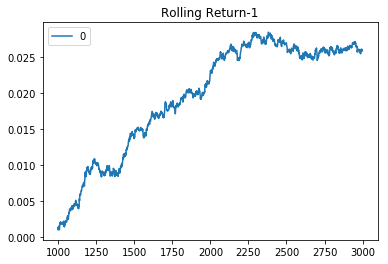

In [20]:
rolling_z = z.rolling(1000).mean()
rolling_plot = rolling_z.plot(title='Rolling Return-1')

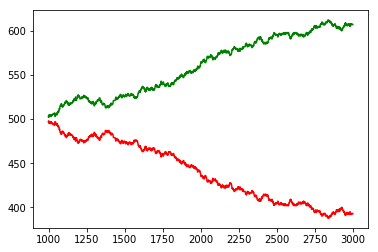

In [21]:
winning_trades = z.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = z.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

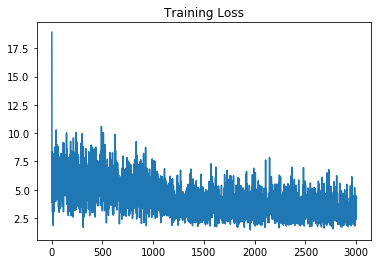

In [22]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

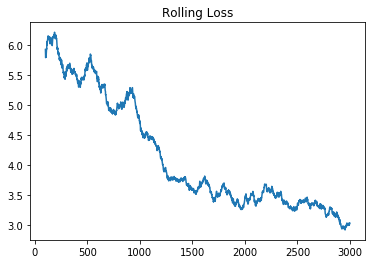

In [23]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

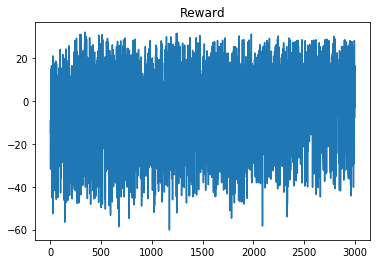

In [24]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

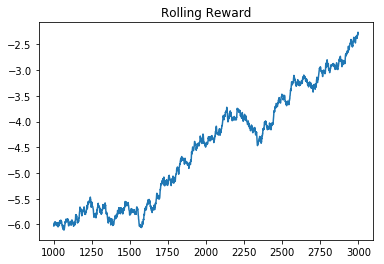

In [25]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
plt.plot(ep[:],reward.rolling(1000).mean())
plt.title('Rolling Reward')
plt.show()

Run episode with trained model:

In [26]:
def run_random(prices,pos_limit,trading_freq):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        elif action*pos<0:
            trade_log.append(action*(abs(pos)+0))
            pos = 0 #action #close all existing positions and apply current action
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

In [27]:
def run_episode(env,pos_limit,trading_freq, verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    if verbose == 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
        plt.plot(plt_df.index,plt_df.Close,color='black')
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

        plt.show()
    return info_log['total_return'], random_return

Return: 0.932
Random return: 1.014


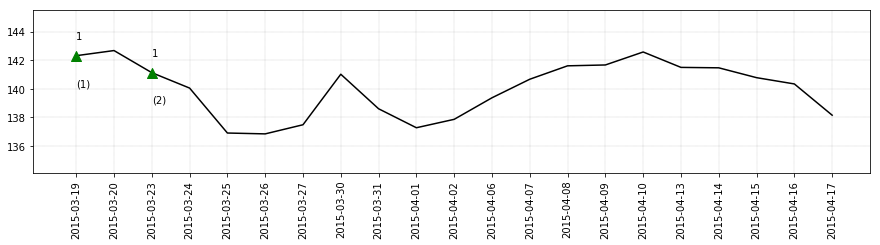

Return: 1.154
Random return: 1.170


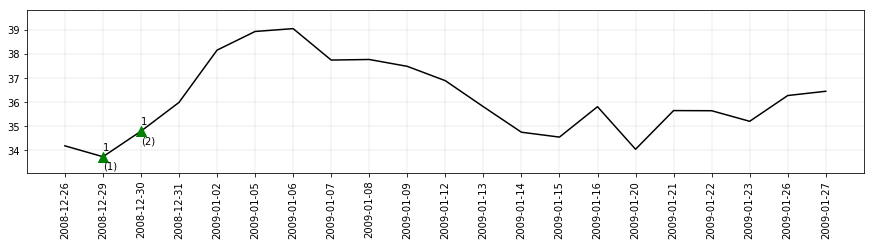

Return: 0.467
Random return: 0.658


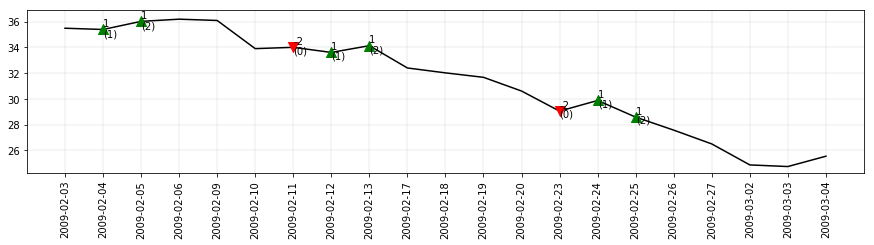

Return: 0.786
Random return: 0.983


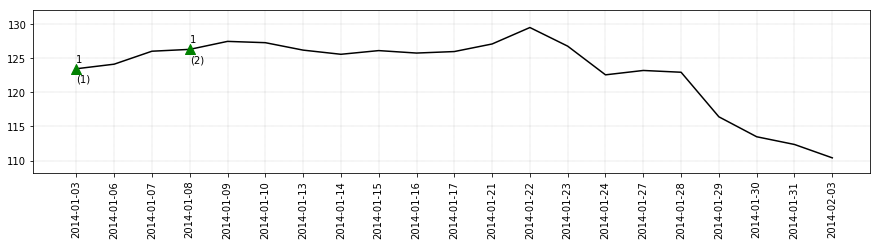

Return: 0.940
Random return: 1.091


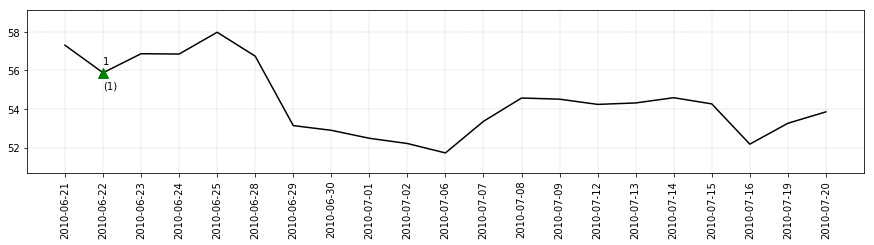

Return: 1.019
Random return: 1.064


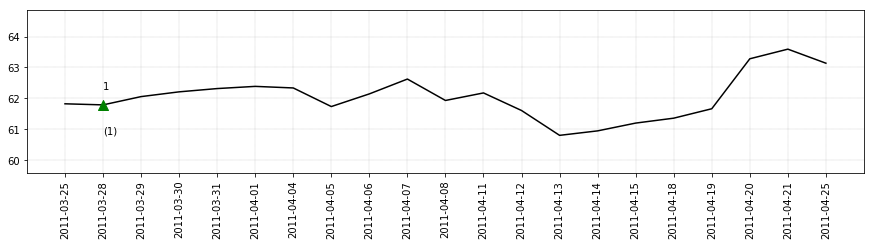

Return: 1.182
Random return: 1.008


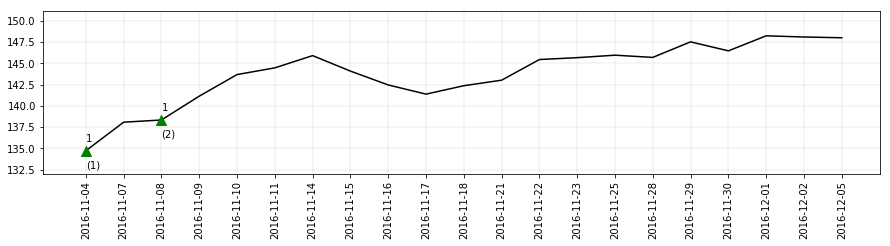

Return: 1.195
Random return: 1.063


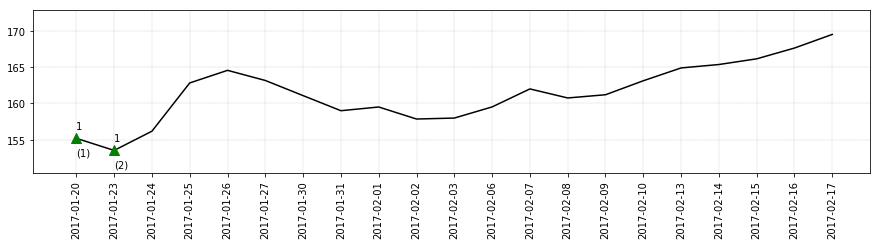

Return: 1.102
Random return: 0.875


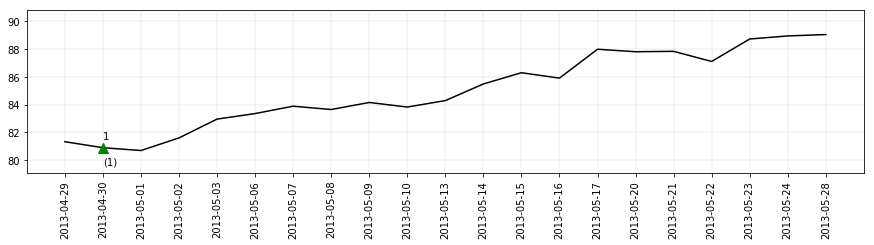

Return: 1.047
Random return: 1.038


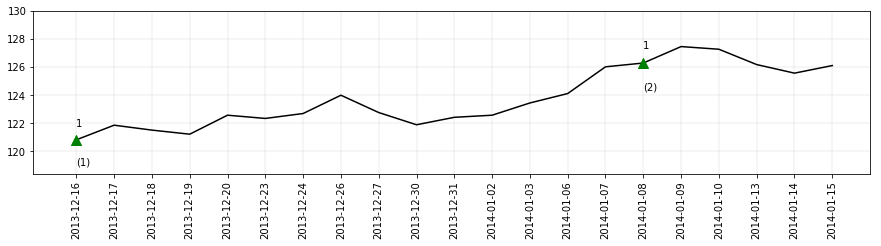

Return: 1.012
Random return: 0.964


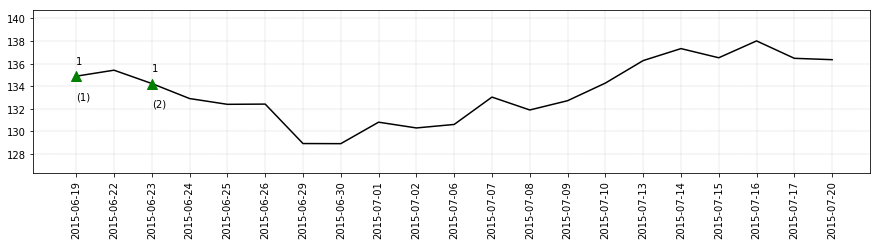

Return: 1.144
Random return: 0.946


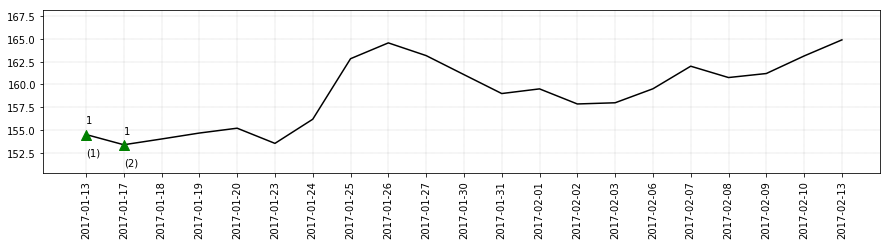

Return: 0.969
Random return: 1.151


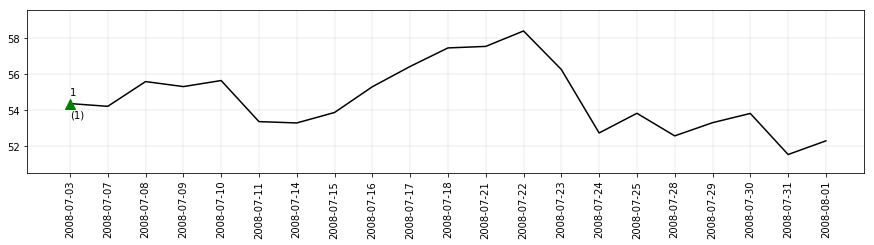

Return: 1.033
Random return: 0.968


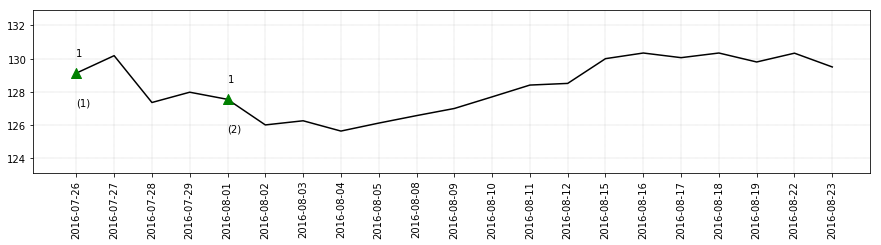

Return: 0.994
Random return: 0.972


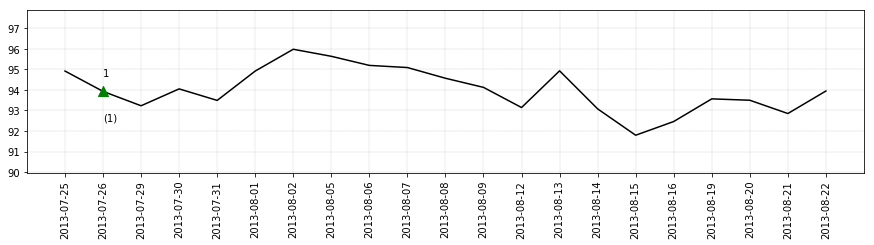

Return: 1.055
Random return: 0.949


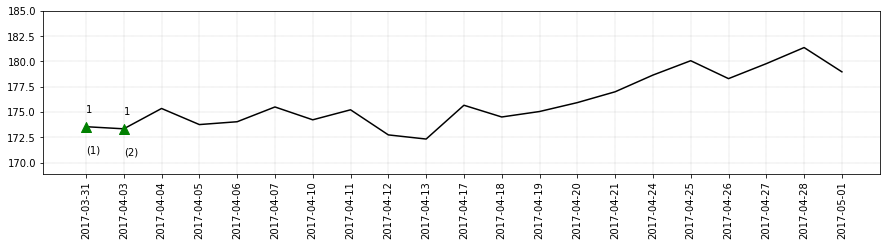

Return: 1.195
Random return: 1.034


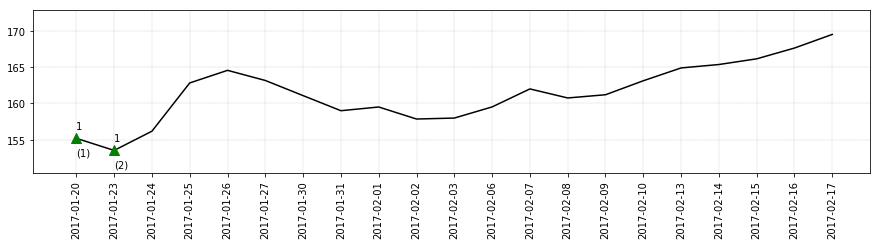

Return: 1.019
Random return: 1.038


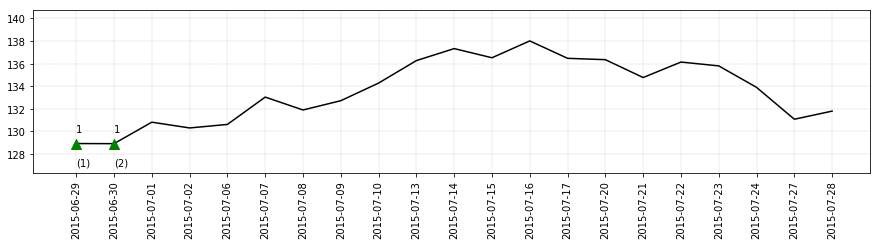

Return: 1.015
Random return: 0.993


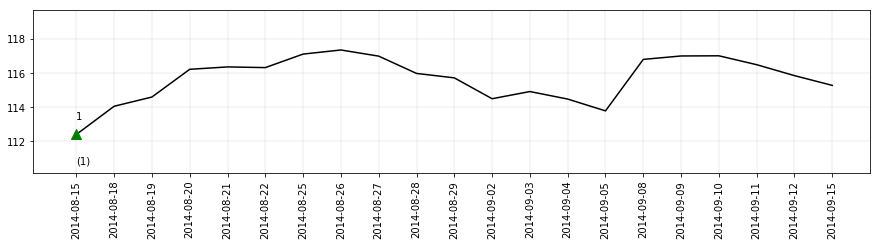

Return: 1.138
Random return: 0.952


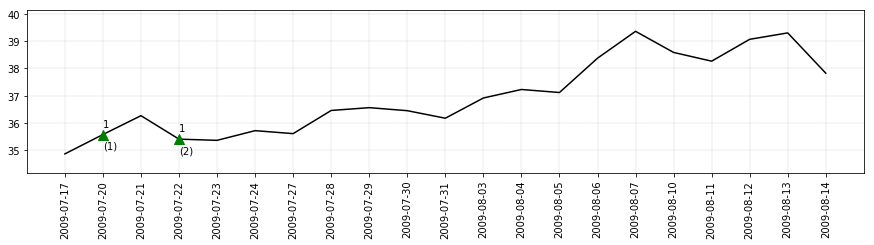

Return: 1.133
Random return: 1.021


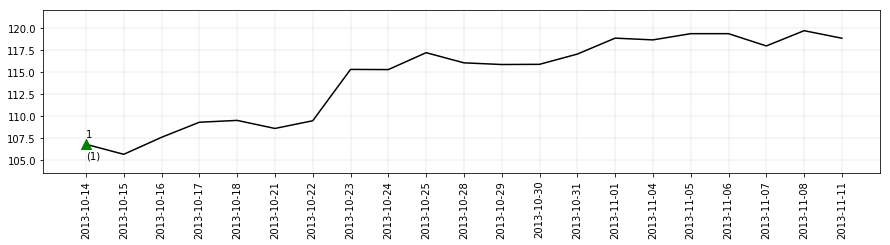

Return: 0.790
Random return: 1.070


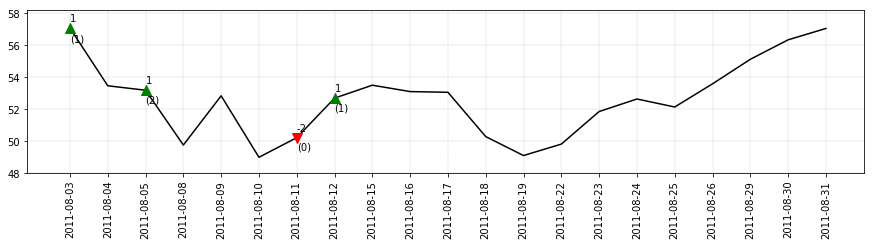

Return: 0.996
Random return: 1.002


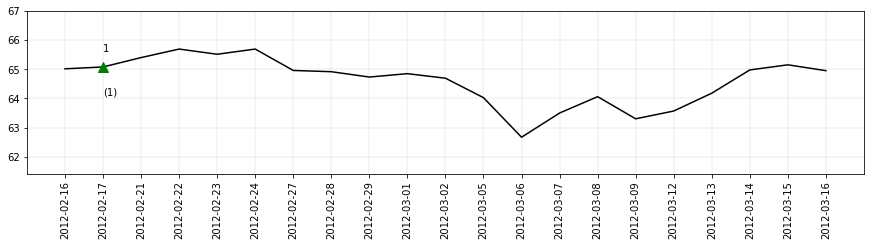

Return: 1.031
Random return: 1.035


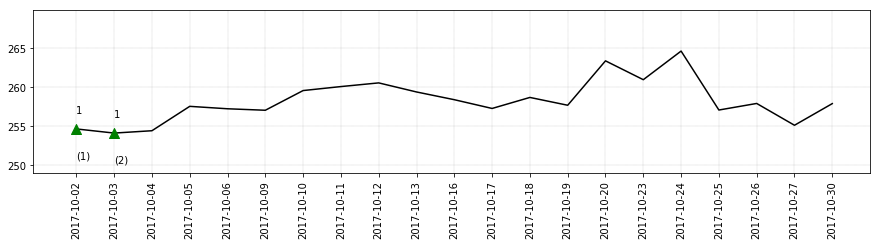

Return: 1.055
Random return: 1.078


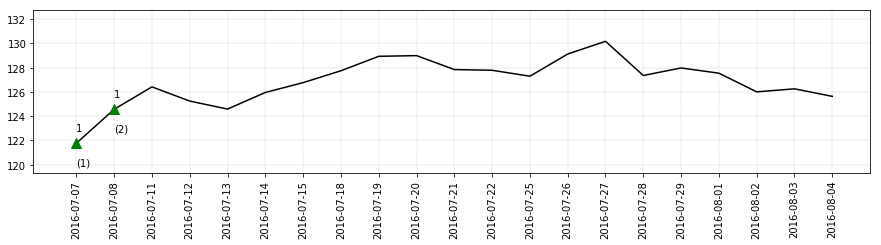

Return: 1.141
Random return: 1.058


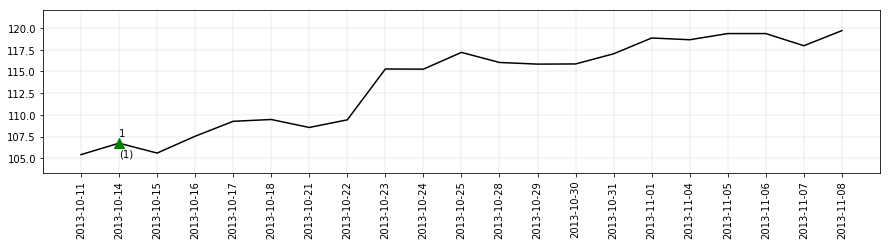

Return: 1.014
Random return: 0.937


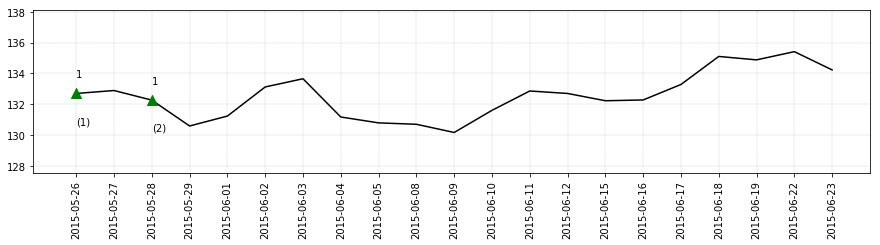

Return: 0.894
Random return: 1.031


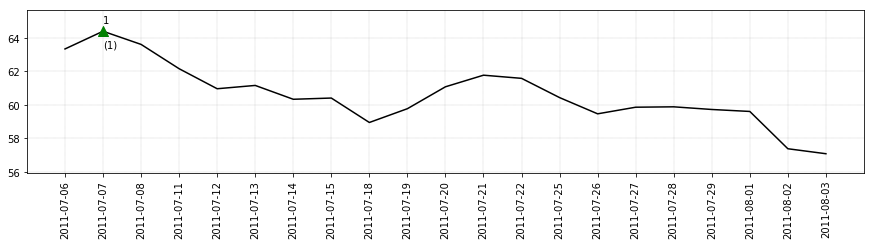

Return: 1.010
Random return: 0.927


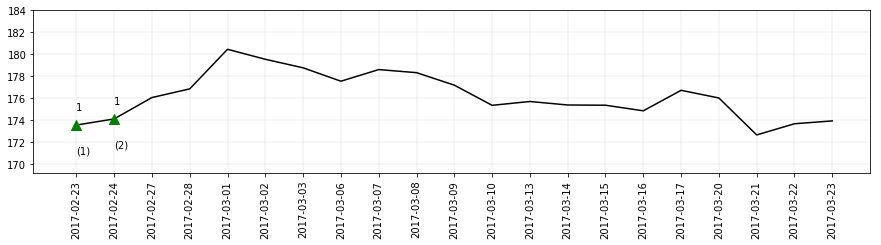

Return: 1.157
Random return: 0.942


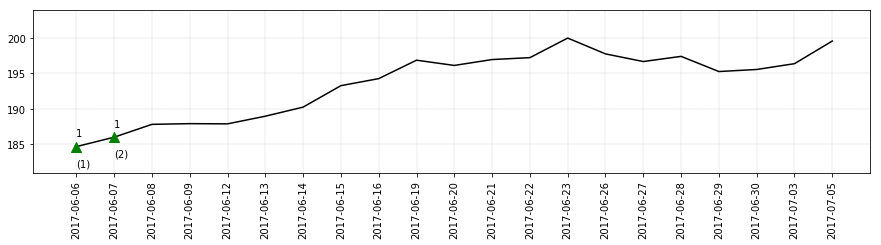

Return: 0.930
Random return: 0.871


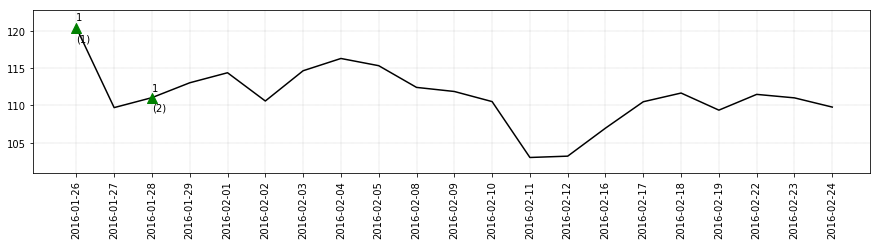

Return: 1.034
Random return: 0.972


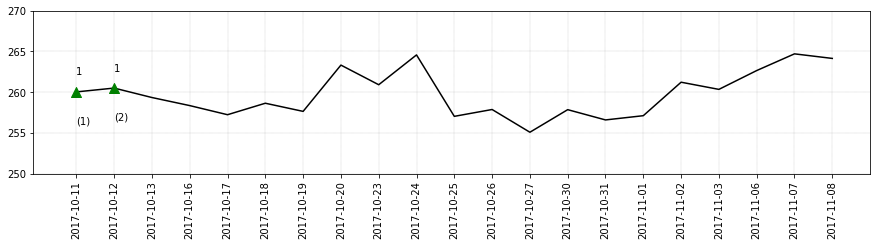

Return: 1.013
Random return: 1.001


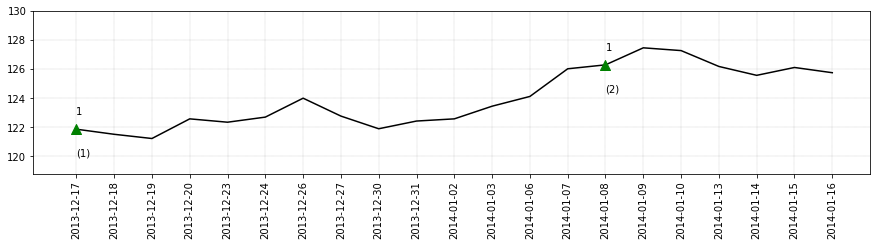

Return: 0.828
Random return: 1.074


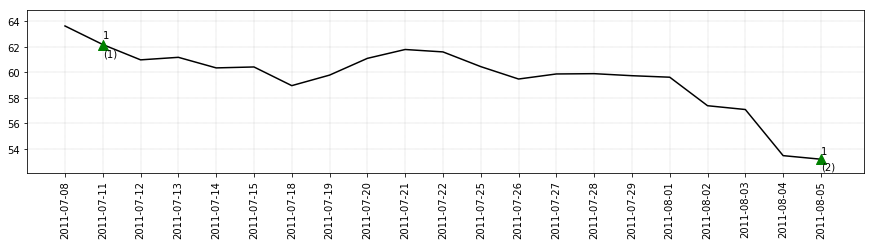

Return: 1.048
Random return: 1.041


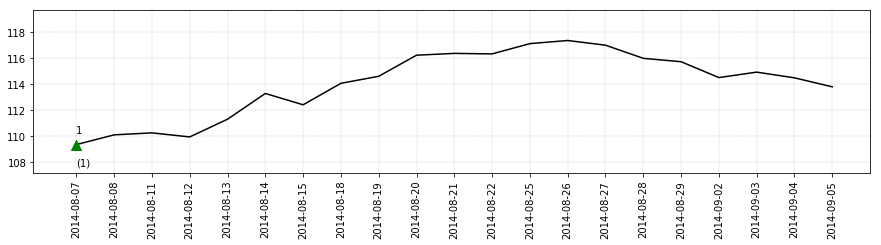

Return: 1.022
Random return: 1.038


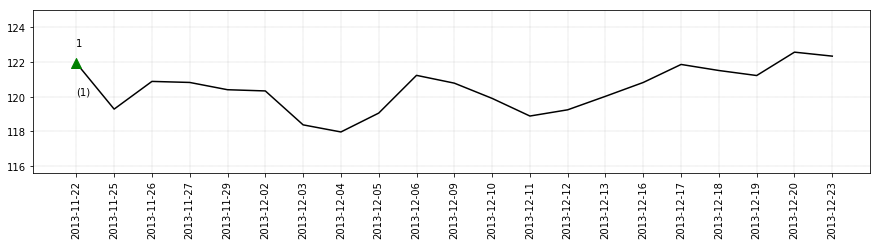

Return: 1.447
Random return: 1.004


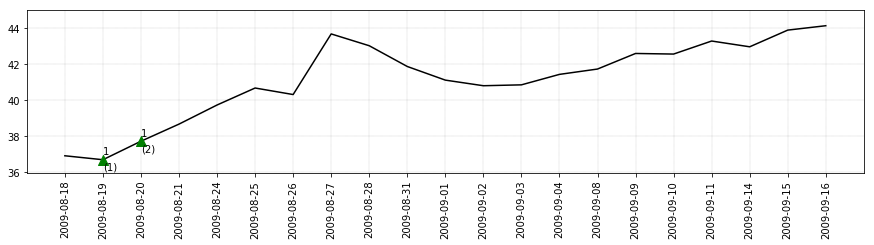

Return: 1.322
Random return: 1.038


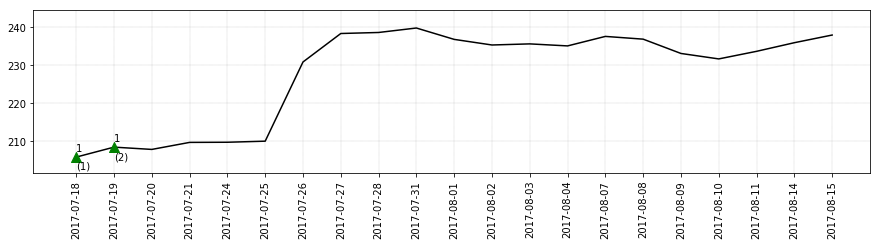

Return: 1.058
Random return: 1.054


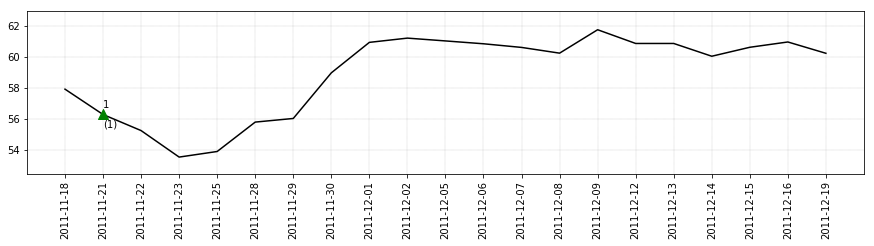

Return: 1.064
Random return: 0.975


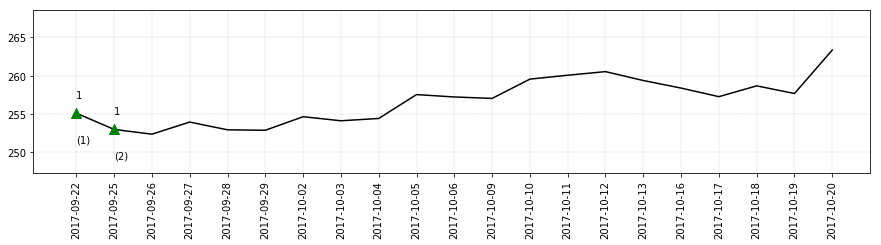

Return: 1.217
Random return: 0.998


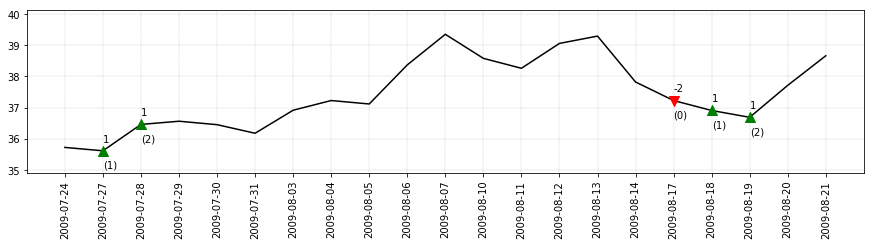

Return: 1.032
Random return: 0.989


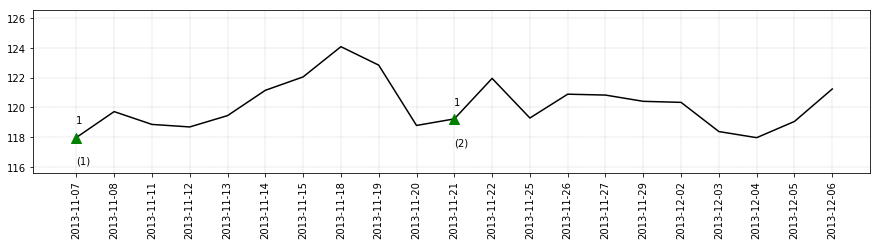

Return: 0.991
Random return: 0.933


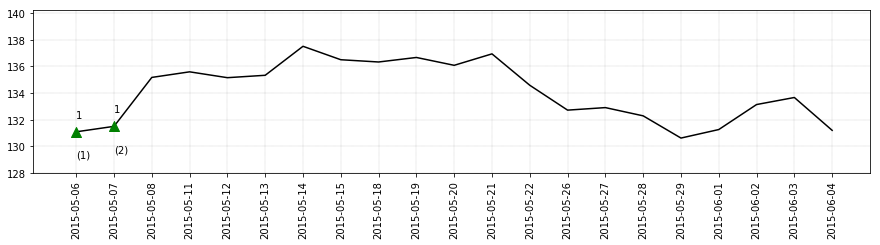

Return: 1.034
Random return: 0.835


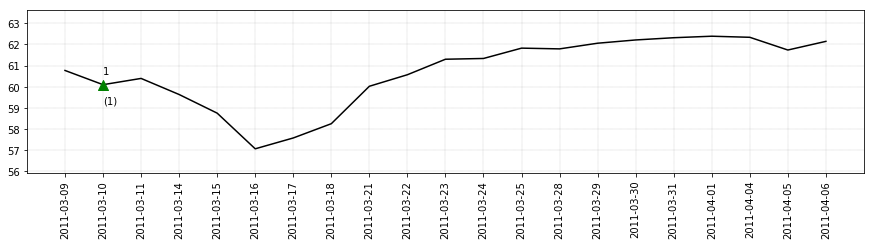

Return: 0.926
Random return: 0.896


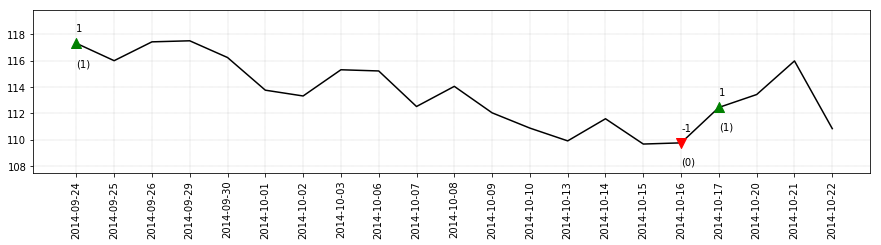

Return: 1.001
Random return: 1.016


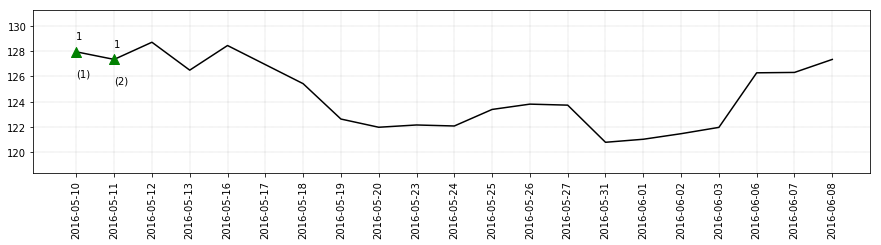

Return: 0.959
Random return: 0.989


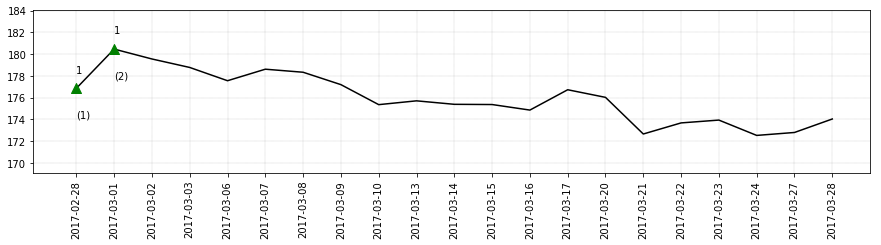

Return: 1.022
Random return: 0.979


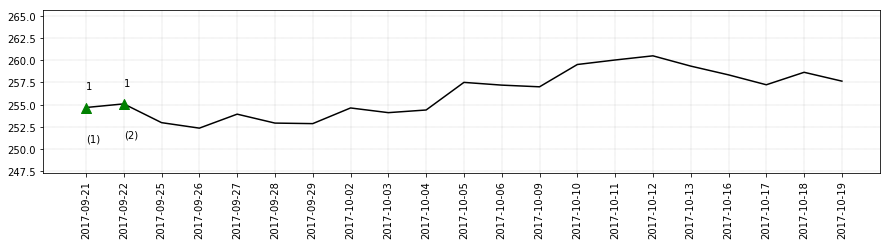

Return: 0.993
Random return: 1.064


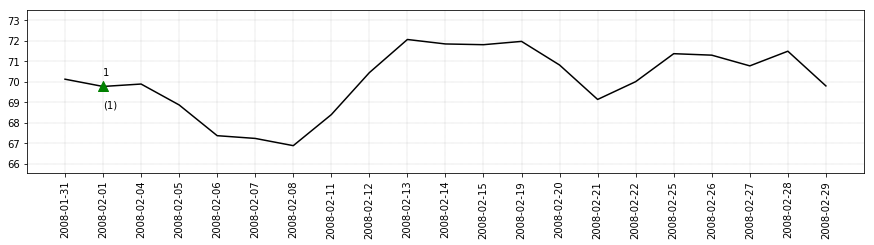

Return: 1.034
Random return: 0.927


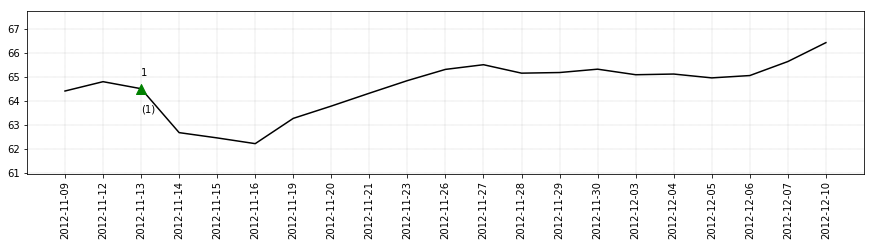

In [28]:
episode_count = 50

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq, verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [29]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (50 episodes): 1.032
Average random return (50 episodes): 0.995
